In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers_PLS import *

# **Visualization for final presentation**

The first plot is the difference between the median of each method when taking only the times where a peak was detected minus the median on the entire method.

In [106]:
def process(all, method):
        all.reset_index(drop=True, inplace=True)
        all['bootstrap_round'] = all.index//12
        all = all[all['Movie'] == 'Spaceman']
        all.loc[all['P-value'] > 0.05, 'Covariance Explained'] = 0.0
        all = all.groupby(['Movie', 'bootstrap_round', 'Region']).sum().reset_index()
        all['Method'] = method
        all['Number of points'] = 7000
        all['Feature'] = 'All Movie'
        all['threshold'] = 0.5
        all['P-value'] = 0.01
        return all

def read_and_process(file_path, method, region):
    df = pd.read_csv(file_path, index_col=0).reset_index()
    return process(df, method)

def preprocess(all, region):
    peaks_bold= pd.DataFrame()
    peaks_scaf= pd.DataFrame()
    peaks_tri= pd.DataFrame()

    if region=='ALL':
        peaks_bold = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_single_pts.csv')
        peaks_scaf = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/PLSpeaks_emotions_single_scaffold_pts.csv')
        peaks_scaf = peaks_scaf.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold', 'LC', 'Method', 'Movie']).last().reset_index()
        peaks_tri = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/triangles_peaks/server_tri/PLSpeaks_emotions_single_triangles_ALL_pts.csv')
        peaks_tri_2 = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/triangles_peaks/enrico_tri/PLSpeaks_emotions_single_triangles_ALL_pts.csv')
        peaks_tri = pd.concat([peaks_tri, peaks_tri_2], axis=0)
    else:
        peaks_bold = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/bold_peaks/PLSpeaks_emotions_single_pts_fn.csv')
        peaks_bold = peaks_bold[peaks_bold['Region'] == region]
        peaks_scaf = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/scaffold_peaks/PLSpeaks_emotions_single_scaffold_{region}_pts.csv')
        peaks_scaf = peaks_scaf.groupby(['Region', 'bootstrap_round', 'Feature', 'Number of points', 'threshold', 'LC', 'Method', 'Movie']).last().reset_index()
        peaks_tri = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/triangles_peaks/PLSpeaks_emotions_single_triangles_{region}_pts.csv')
    
    peaks_bold['Method'] = 'bold'

    peaks_data = pd.concat([peaks_bold, peaks_scaf, peaks_tri, all], axis=0)
    peaks_data = peaks_data[~peaks_data['Feature'].str.contains('Control')]
    peaks_data = peaks_data[(peaks_data['Movie'] == 'Spaceman') & (peaks_data['Region'] == region)]
    return peaks_data

def calculate_difference(row, all_movie_values):
    return row['Covariance Explained'] - all_movie_values.loc[row['Method'], 'Covariance Explained']

def median_peaks_computation(peaks_data):
    peaks_data.loc[peaks_data['P-value'] > 0.05, 'Covariance Explained'] = 0.0
    significant = peaks_data.copy()
    significant = significant.groupby(['Region', 'Feature', 'Number of points', 'Movie', 'Method', 'bootstrap_round']).sum().reset_index()
    median_data = significant.groupby(['Method', 'Region', 'Feature', 'Number of points', 'Movie']).median().reset_index().drop(columns = ['P-value', 'Movie', 'Region', 'bootstrap_round', 'LC', 'threshold'])
    median_data = median_data[median_data['Number of points'] != 20]
    median_data = median_data[median_data['Number of points'] != 100]
    median_data = median_data[median_data['Number of points'] != 150]
    return median_data

def draw_barplot(data, **kwargs):
    palette = sns.color_palette("Set2", 3)
    ax = sns.barplot(x='Number of points', y='Difference Explained', hue = "Method", data=data, palette = palette, hue_order=['bold', 'scaffold', 'triangles'], **kwargs)
    ax.grid(axis='y', alpha=0.5)

def plot(difference_df, region):
    palette = sns.color_palette("Set2", 3)
    grid = sns.FacetGrid(difference_df, col="Feature", palette=palette, col_wrap=2, height=4.5, sharex=False)
    grid.fig.subplots_adjust(top=0.9)
    if region == 'ALL':
        grid.fig.suptitle(f'Difference in Covariance Explained for Whole Brain', fontsize=20, fontweight='bold')
    else:
        grid.fig.suptitle(f'Difference in Covariance Explained for {region} Yeo Network', fontsize=20)
    # fontsize axis
    for ax in grid.axes.flat:
        ax.tick_params(labelsize=14)
        ax.set_xlabel('Number of points', fontsize=16)
        ax.set_ylabel('Difference in Covariance Explained', fontsize=16)
    grid.map_dataframe(draw_barplot)
    grid.add_legend(fontsize=14)
    grid.set(ylim=(-0.3, 0.35))
    plt.show()

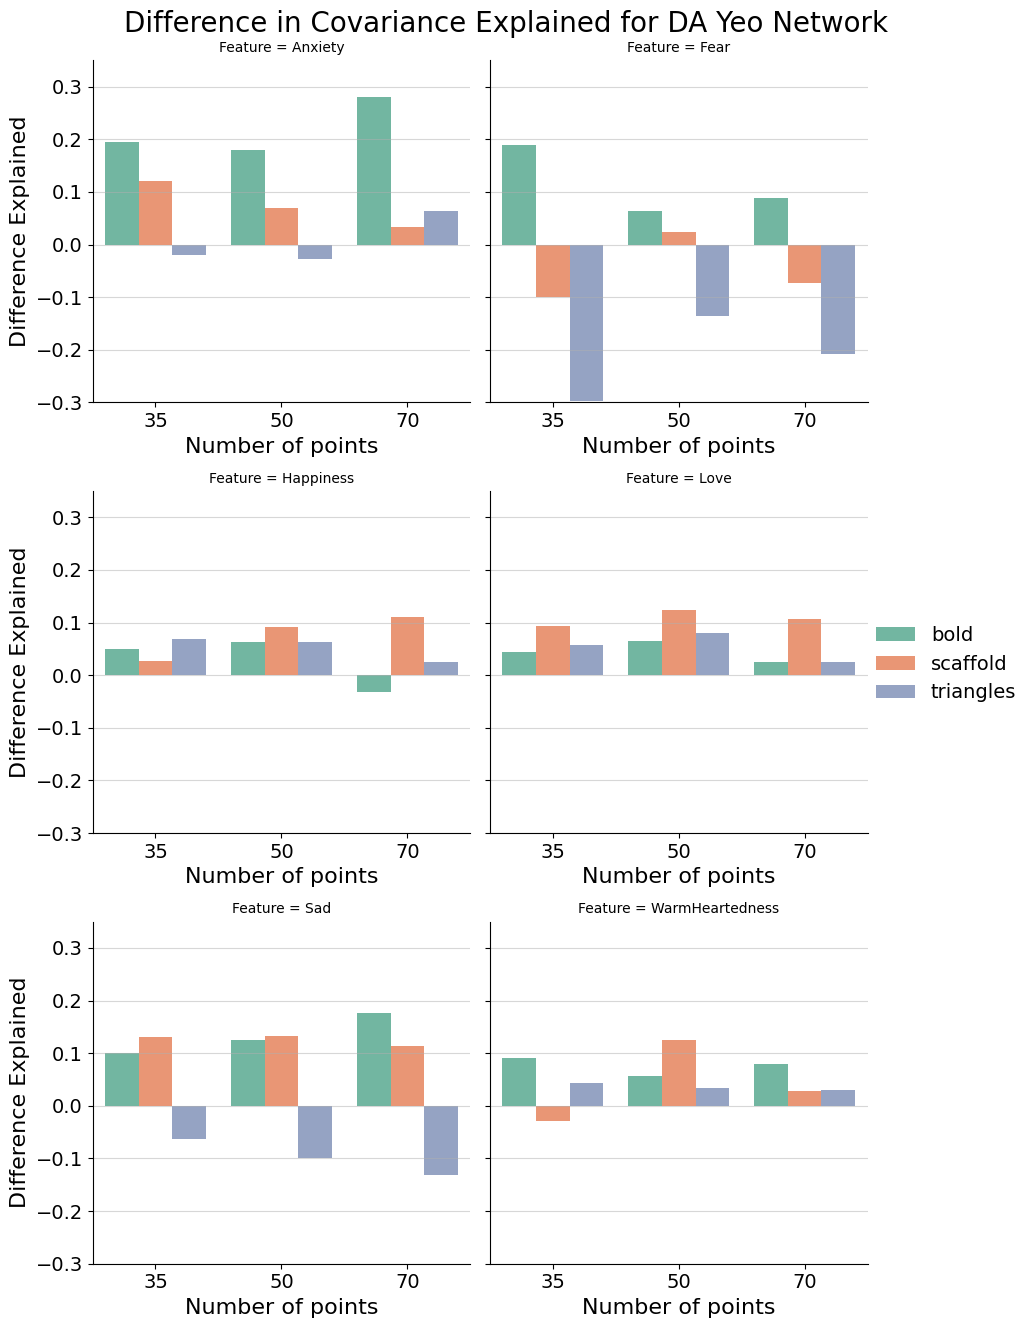

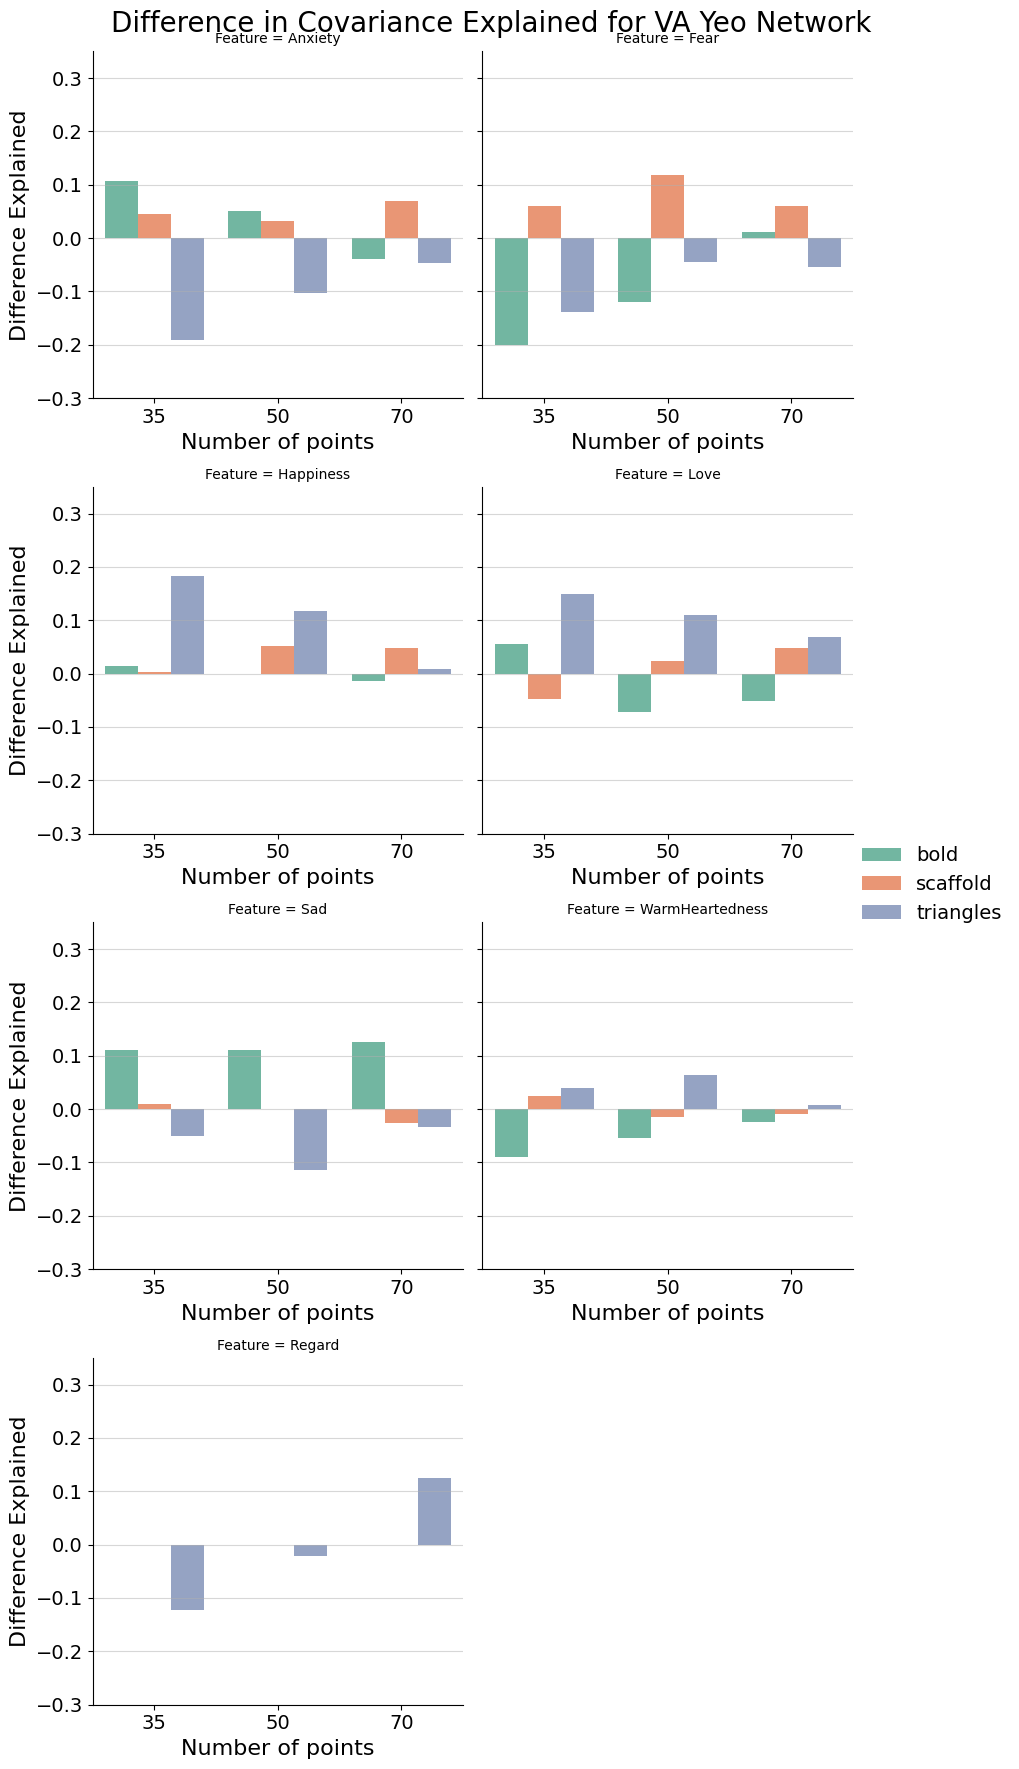

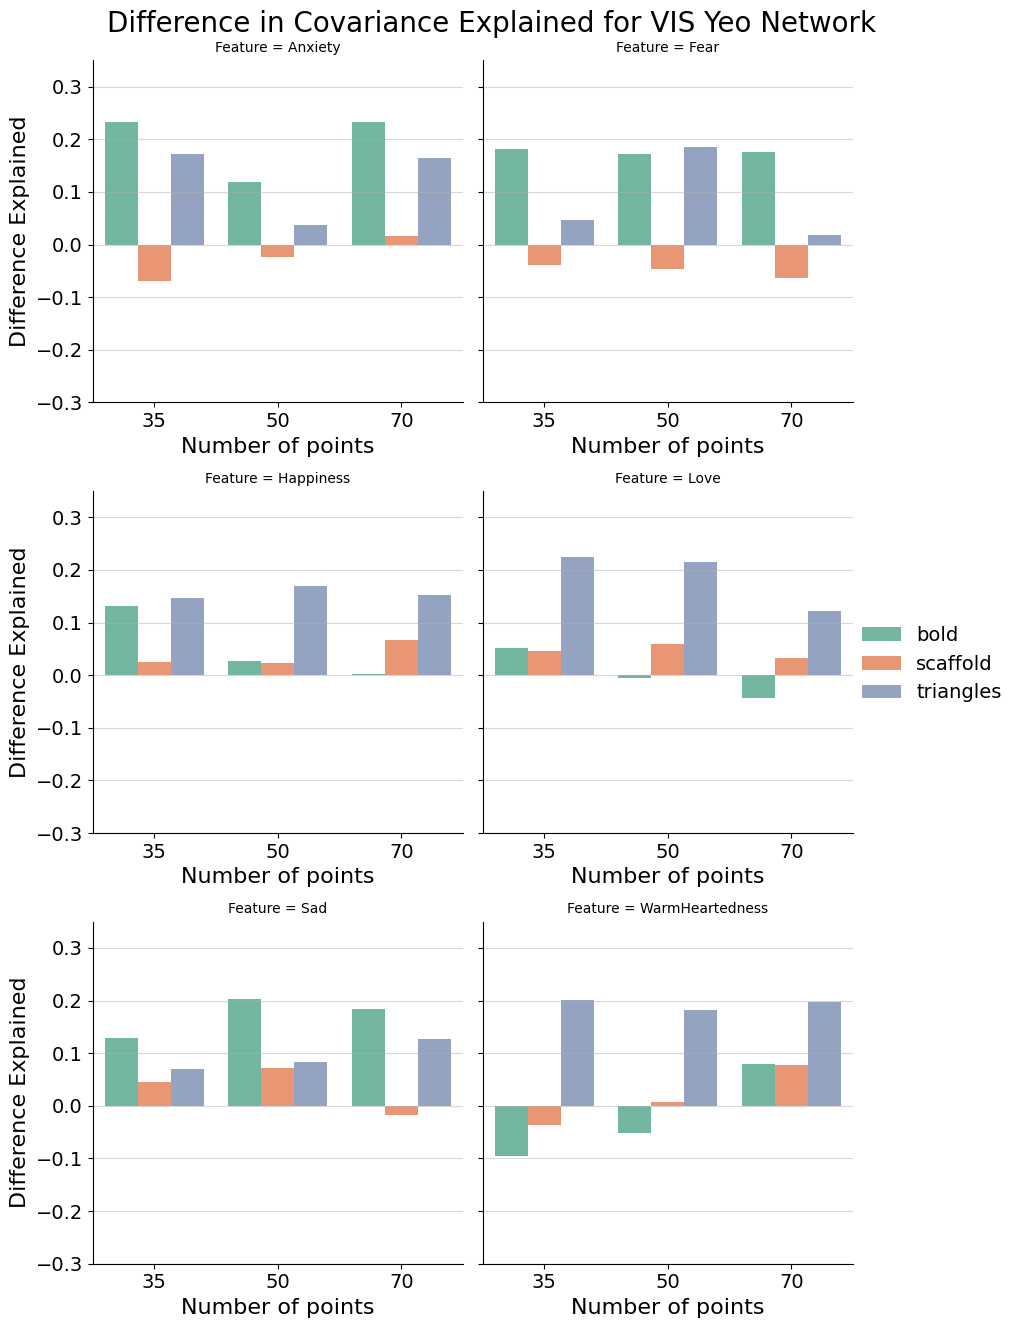

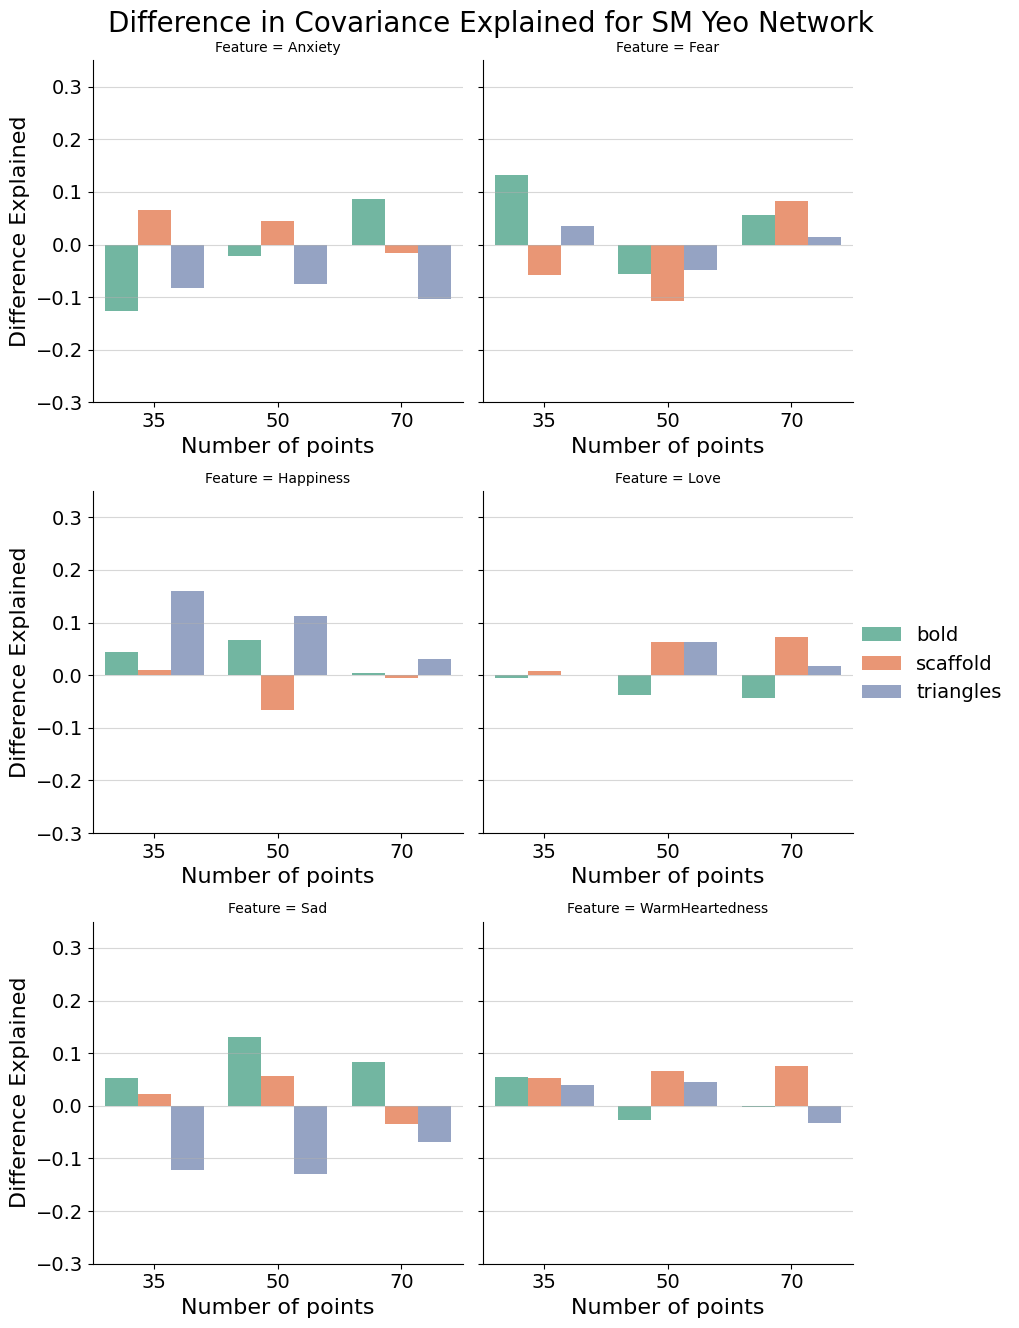

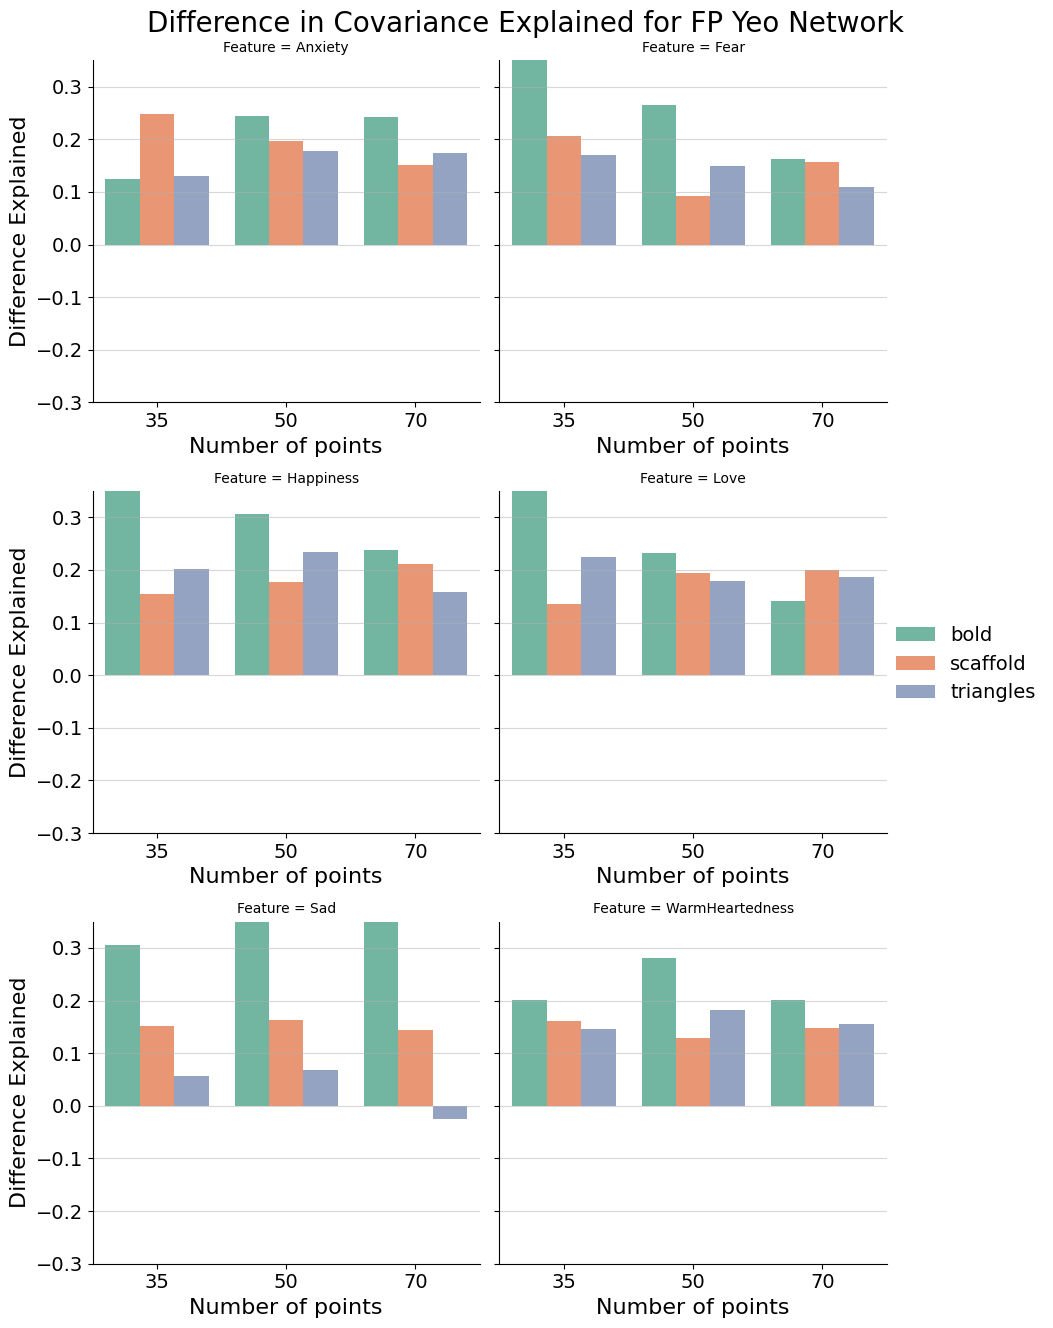

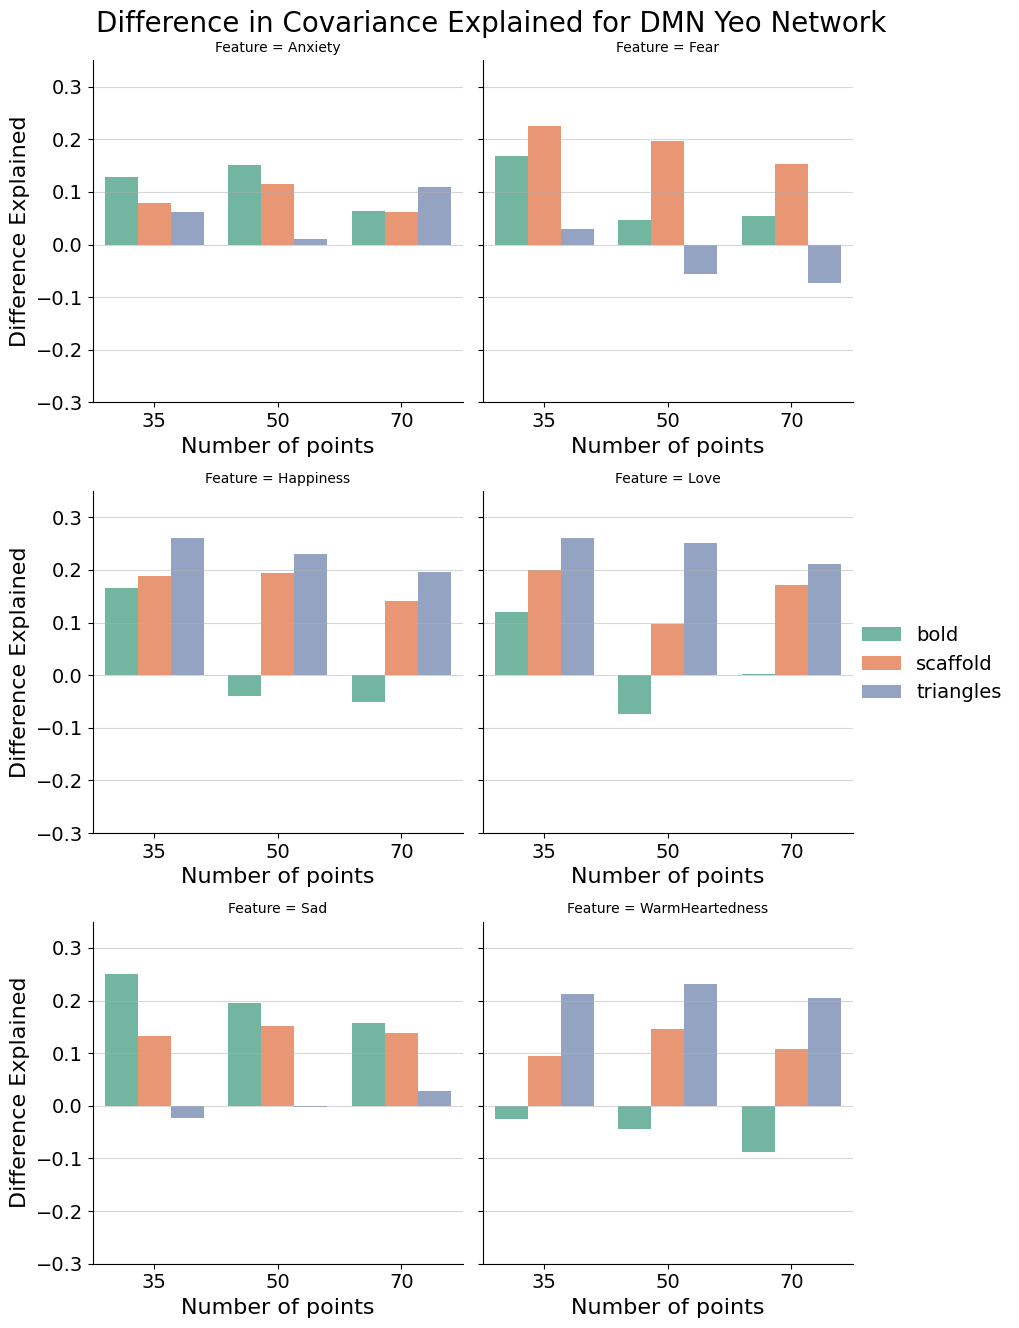

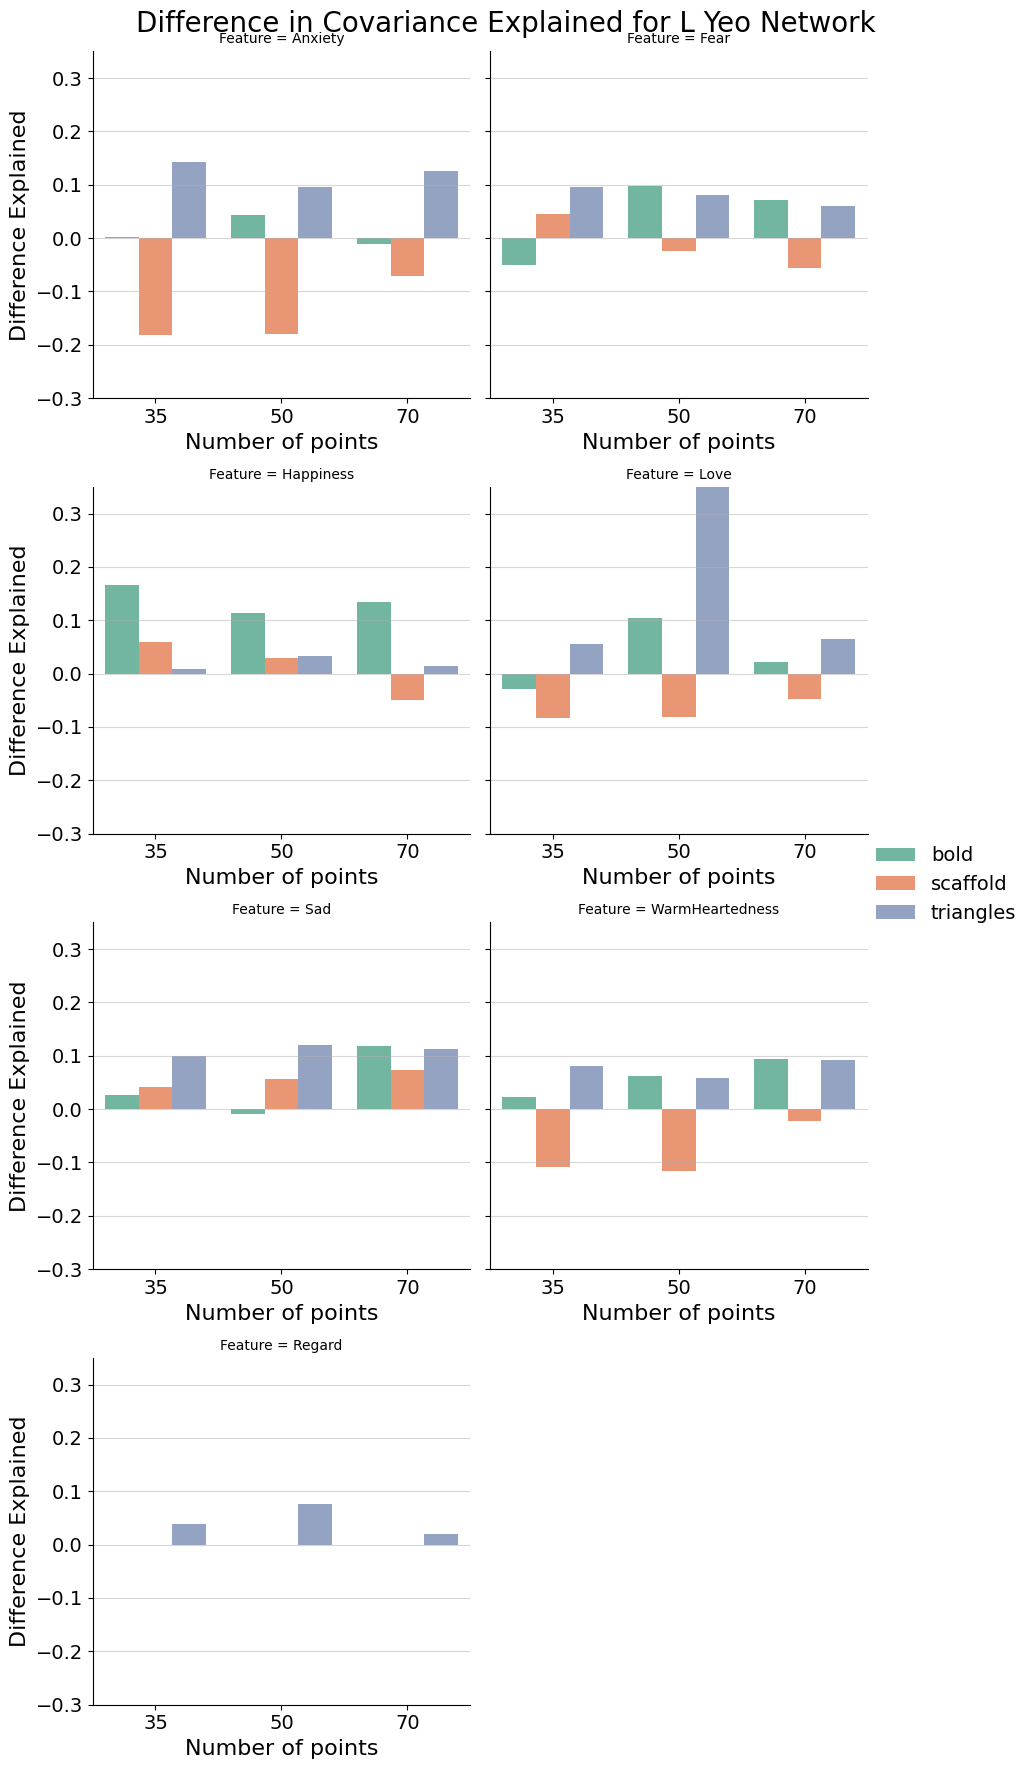

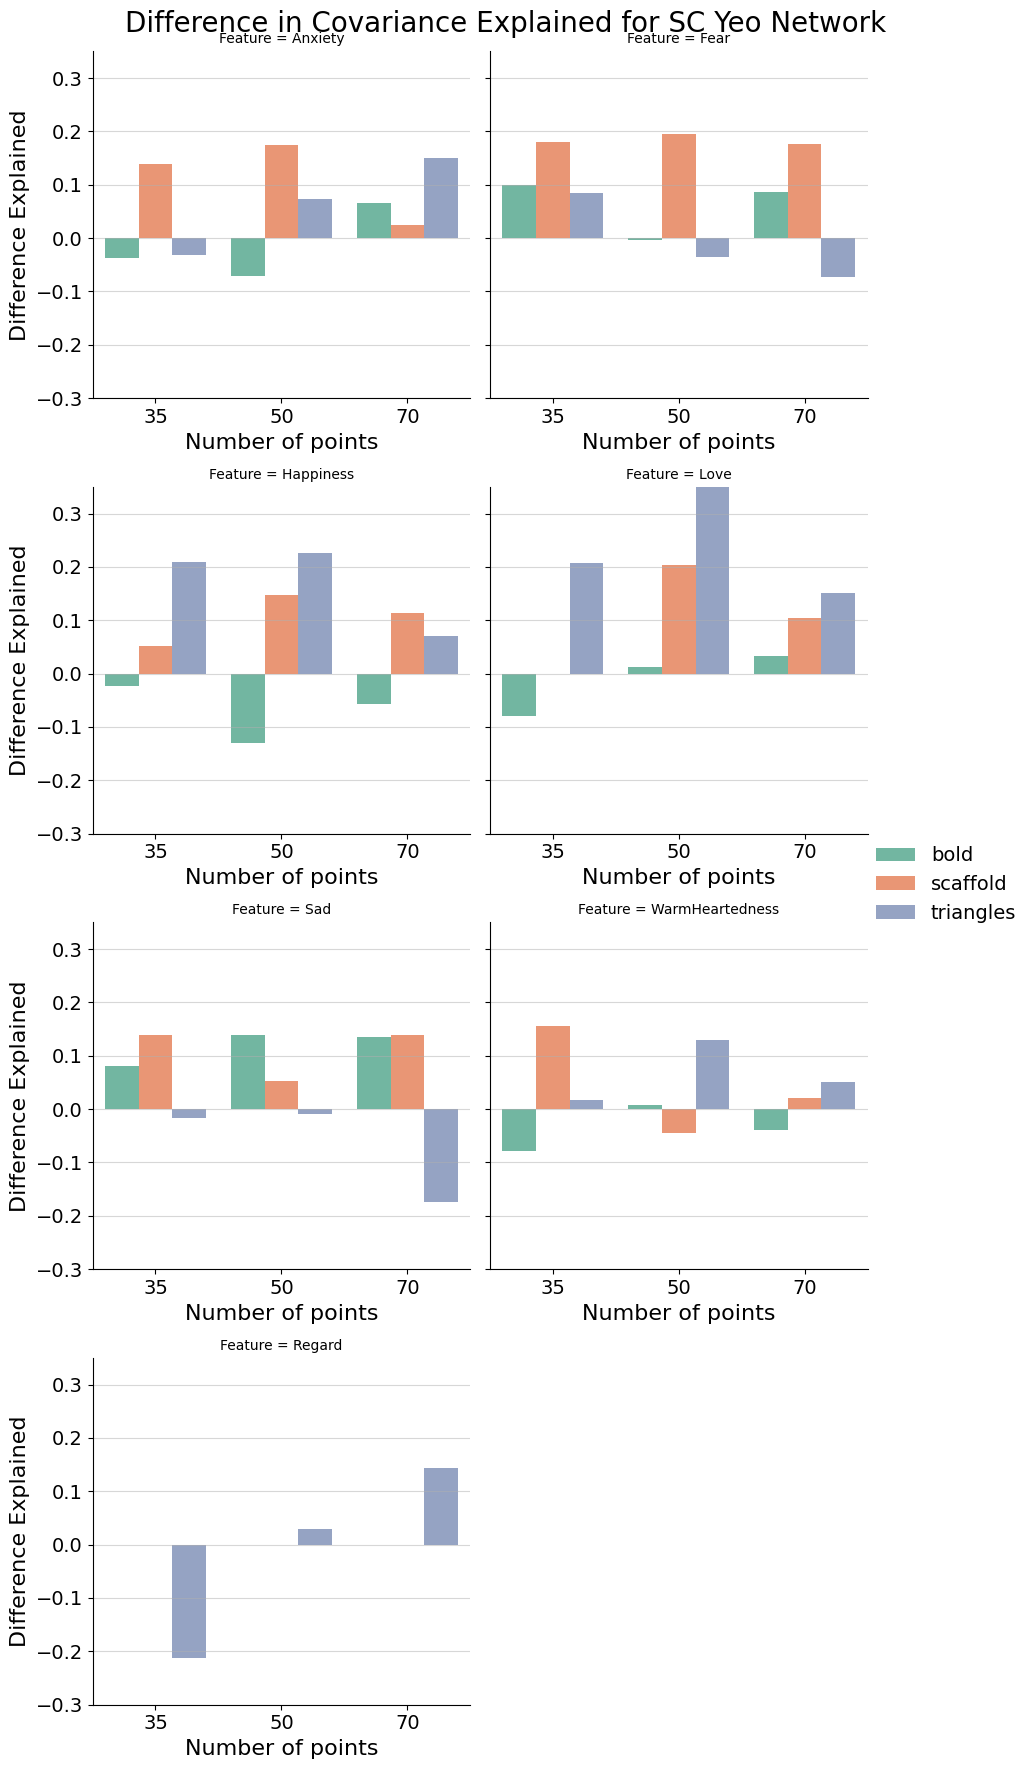

In [108]:
for region in ['DA','VA', 'VIS', 'SM', 'FP', 'DMN', 'L', 'SC']:
    
    # Read the data
    all_bold = read_and_process(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_bold_{region}_bootstrap_results.csv', 'bold', region)
    all_scaf = read_and_process(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_scaffold_{region}_bootstrap_results.csv', 'scaffold', region)
    all_tri = read_and_process(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_triangles_{region}_bootstrap_results.csv', 'triangles', region)
    all = pd.concat([all_bold, all_scaf, all_tri])
    
    # Get the median data
    peaks_data = preprocess(all, region)
    df = median_peaks_computation(peaks_data)
    
    # Difference computation
    difference_df = df[df['Feature'] != 'All Movie'].copy()
    all_movie_values = df[df['Feature'] == 'All Movie'].set_index('Method')
    difference_df['Difference Explained'] = difference_df.apply(calculate_difference, axis=1, args=(all_movie_values,))
    difference_df = difference_df[['Method', 'Feature', 'Number of points', 'Difference Explained']]

    # PLOT
    # create a 4 x 2 grid of subplots
    ax, fig = plt.subplots(4, 2, figsize=(40, 40))
    

    palette = sns.color_palette("Set2", 3)
    grid = sns.FacetGrid(difference_df, col="Feature", palette=palette, col_wrap=2, height=4.5, sharex=False)
    grid.fig.subplots_adjust(top=0.9)
    if region == 'ALL':
        grid.fig.suptitle(f'Difference in Covariance Explained for Whole Brain', fontsize=20, fontweight='bold')
    else:
        grid.fig.suptitle(f'Difference in Covariance Explained for {region} Yeo Network', fontsize=20)
    # fontsize axis
    for ax in grid.axes.flat:
        ax.tick_params(labelsize=14)
        ax.set_xlabel('Number of points', fontsize=16)
        ax.set_ylabel('Difference in Covariance Explained', fontsize=16)
    grid.map_dataframe(draw_barplot)
    grid.add_legend(fontsize=14)
    grid.set(ylim=(-0.3, 0.35))
    plt.show() 
    


In [182]:
# Initialize an empty list to store DataFrames
dfs = []

for region in ['DA','VA', 'VIS', 'SM', 'FP', 'DMN', 'L', 'SC']:
    
    # Read the data
    all_bold = read_and_process(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_bold_{region}_bootstrap_results.csv', 'bold', region)
    all_scaf = read_and_process(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_scaffold_{region}_bootstrap_results.csv', 'scaffold', region)
    all_tri = read_and_process(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_triangles_{region}_bootstrap_results.csv', 'triangles', region)
    all = pd.concat([all_bold, all_scaf, all_tri])
    
    # Get the median data
    peaks_data = preprocess(all, region)
    df = median_peaks_computation(peaks_data)
    
    # Difference computation
    difference_df = df[df['Feature'] != 'All Movie'].copy()
    all_movie_values = df[df['Feature'] == 'All Movie'].set_index('Method')
    difference_df['Difference Explained'] = difference_df.apply(calculate_difference, axis=1, args=(all_movie_values,))
    difference_df = difference_df[['Method', 'Feature', 'Number of points', 'Difference Explained']]
    difference_df['Region'] = region

    # keep only the columns  Method          Feature  Number of points  Difference Explained Region
    difference_df = difference_df[['Method', 'Feature', 'Number of points', 'Difference Explained', 'Region']]
    difference_df.reset_index(drop=True, inplace=True)
    # Append the current DataFrame to the list
    dfs.append(difference_df)

# Concatenate all DataFrames in the list
result_df = pd.concat(dfs, axis=0, ignore_index=True)
result_df = result_df.loc[result_df['Number of points'] == 35, :]
result_df

,Method,Feature,Number of points,Difference Explained,Region
0,bold,Anxiety,35,0.194632,DA
3,bold,Fear,35,0.189354,DA
6,bold,Happiness,35,0.050343,DA
9,bold,Love,35,0.044636,DA
12,bold,Sad,35,0.100086,DA
...,...,...,...,...,...
424,triangles,Happiness,35,0.208511,SC
427,triangles,Love,35,0.206427,SC
430,triangles,Regard,35,-0.212747,SC
433,triangles,Sad,35,-0.016607,SC


In [183]:
result_df['Comparisons'] = result_df.apply(lambda row: f"{row['Feature']}_{row['Number of points']}_All movie_7000", axis=1)
result_df

,Method,Feature,Number of points,Difference Explained,Region,Comparisons
0,bold,Anxiety,35,0.194632,DA,Anxiety_35_All movie_7000
3,bold,Fear,35,0.189354,DA,Fear_35_All movie_7000
6,bold,Happiness,35,0.050343,DA,Happiness_35_All movie_7000
9,bold,Love,35,0.044636,DA,Love_35_All movie_7000
12,bold,Sad,35,0.100086,DA,Sad_35_All movie_7000
...,...,...,...,...,...,...
424,triangles,Happiness,35,0.208511,SC,Happiness_35_All movie_7000
427,triangles,Love,35,0.206427,SC,Love_35_All movie_7000
430,triangles,Regard,35,-0.212747,SC,Regard_35_All movie_7000
433,triangles,Sad,35,-0.016607,SC,Sad_35_All movie_7000


In [190]:
stats_df_bold = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/stats_df_bold.csv')
stats_df_scaf = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/stats_df_scaffold.csv')
stats_df_tri = pd.read_csv('/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_emoPeaks/stats_df_triangles.csv')
stats_df = pd.concat([stats_df_bold, stats_df_scaf, stats_df_tri], axis=0)

stats_df['Comparisons'] = stats_df['Comparisons'].astype(str)

# Define a function to extract the desired information from the 'Comparisons' column
def extract_comparison(row):
    comparison_list = eval(row)  # Convert the string representation to a list
    result = "_".join([f"{item[0]}_{item[1]}" for item in comparison_list])
    return result

# Apply the function to create the new 'Comparisons' column
stats_df['Comparisons'] = stats_df['Comparisons'].apply(extract_comparison)

stats_df.drop(columns=['Unnamed: 0'], inplace=True)

# drop rows with Movie == 'concatenated'
stats_df = stats_df[stats_df['Movie'] != 'concatenated']
for emotion in ['Love', 'Sad', 'Anxiety', 'Fear', 'Happiness', 'WarmHeartedness']:
    stats_df.loc[stats_df['Comparisons'] == f'{emotion}_50_All movie_7000', 'Comparisons'] = f'{emotion}_35_All movie_7000'
stats_df

,Method,Region,Annotations,Comparisons,Movie
0,bold,SC,ns,Anxiety_70_Anxiety_35,Spaceman
1,bold,SC,ns,Anxiety_50_Anxiety_35,Spaceman
2,bold,SC,ns,Fear_70_Fear_35,Spaceman
3,bold,SC,ns,Fear_50_Fear_35,Spaceman
4,bold,SC,ns,Happiness_70_Happiness_35,Spaceman
...,...,...,...,...,...
135,triangles,L,ns,Fear_35_All movie_7000,Spaceman
136,triangles,L,ns,Happiness_35_All movie_7000,Spaceman
137,triangles,L,ns,Love_35_All movie_7000,Spaceman
138,triangles,L,ns,Sad_35_All movie_7000,Spaceman


In [191]:
# merge stats_df and result_df on Method Region Comparisons
merged_df = pd.merge(stats_df, result_df, on=['Method', 'Region', 'Comparisons'], how='inner')
merged_df = merged_df[merged_df['Annotations'] != 'ns']

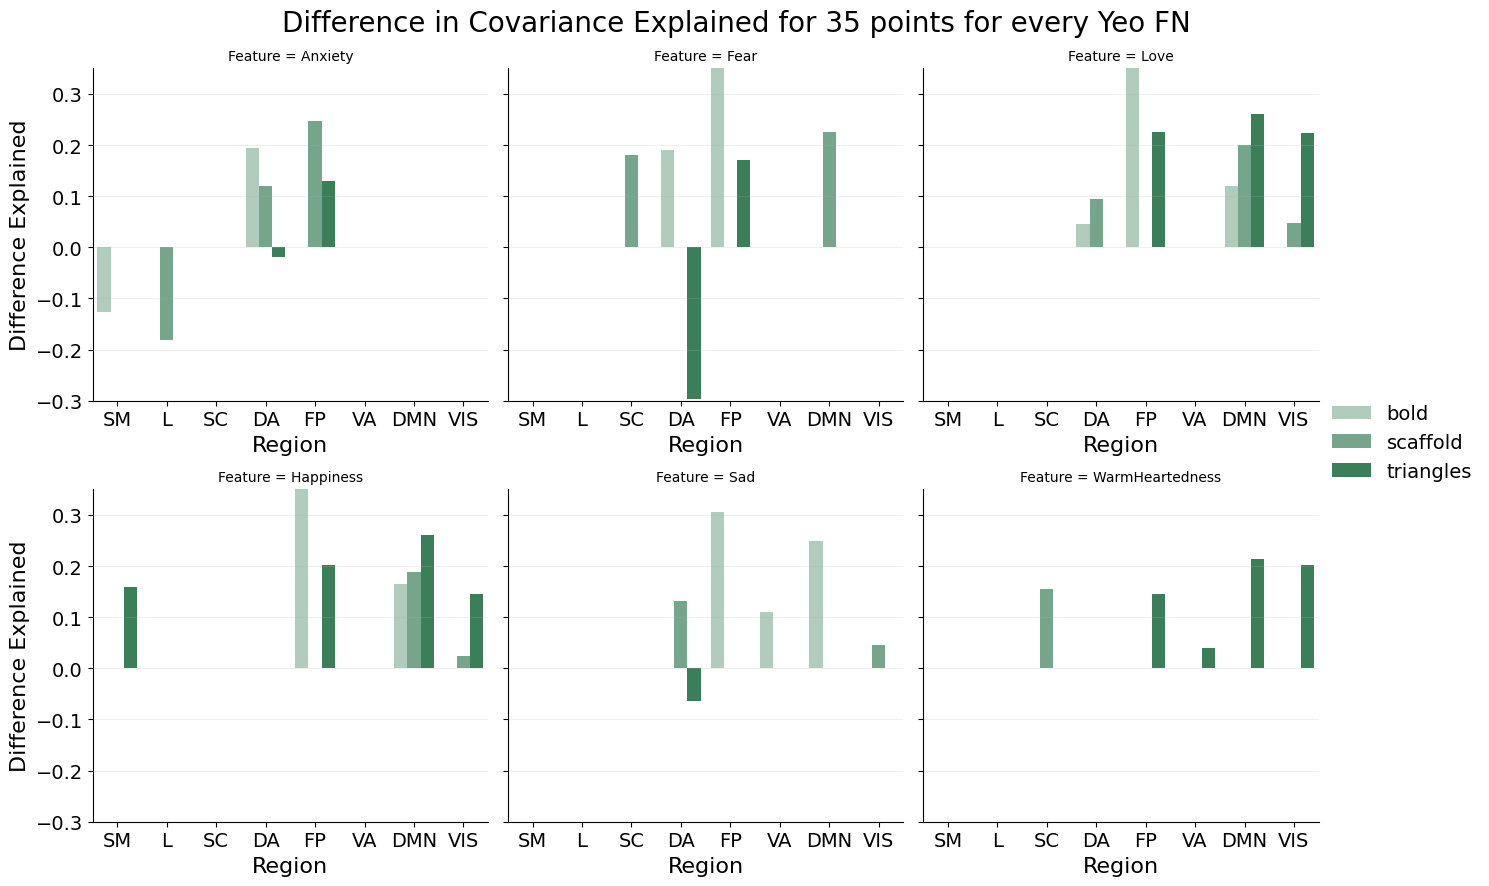

In [193]:
# remove feature regard

merged_df = merged_df[merged_df['Feature'] != 'Regard']

def draw_barplot(data, **kwargs):
    palette = sns.light_palette('seagreen', 4)[1:]
    
    ax = sns.barplot(x='Region', y='Difference Explained', hue = "Method", data=data, palette = palette, hue_order=['bold', 'scaffold', 'triangles'], 
                     order = ['SM',  'L', 'SC', 'DA', 'FP', 'VA', 'DMN', 'VIS'], **kwargs)
    ax.grid(axis='y', alpha=0.2)

palette = sns.color_palette("Set2", 3)
grid = sns.FacetGrid(merged_df, col="Feature", palette=palette, col_wrap=3, height=4.5, sharex=False)
for ax in grid.axes.flat:
    ax.tick_params(labelsize=14)
    ax.set_xlabel('Region', fontsize=16)
    ax.set_ylabel('Difference in Covariance Explained', fontsize=16)

# add title
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle(f'Difference in Covariance Explained for 35 points for every Yeo FN', fontsize=20)
grid.map_dataframe(draw_barplot)
grid.add_legend(fontsize=14)
grid.set(ylim=(-0.3, 0.35))
plt.show() 